## Variational Quantum Eigensolver for ground state energy
In quantum chemistry, we can use the Variational Quantum Eigensolver (VQE) to solve for the ground state energy of the electronic Hamiltonian. Mapped to a sum of Pauli strings the electronic Hamiltonian has the following form
$$\hat{H}_{\text{el}} = \sum\limits_{k=1}^K c_k \hat{P}_k \,, $$
where $c_k$ are complex-valued coefficients, and the Paulis strings $\hat{P}_k \in \{\mathbf{1}, X, Y, Z \}^{\otimes n}$ are tensor products of the Pauli matrices (+ identity matrix).  
Details about the electronic Hamiltonian and how it is mapped to qubits are provided in lecture 1 and 2 of this course.

Given a parameterized trial wave function $| \psi(\theta) \rangle$ characterized by a set of parameters $\theta$, the energy is given as the expectation value of the Hamiltonian $\hat{H}$ with respect to $| \psi(\theta) \rangle$,
$$ E = \langle \hat{H} \rangle = \langle \psi(\theta) | \hat{H} | \psi(\theta) \rangle \,. $$

The VQE algorithm then consists of the following steps: We prepare the trial wave function $| \psi(\theta) \rangle$ on a quantum computer and measure the expectation values of the Pauli strings $\langle \hat{P}_k \rangle$. The expectation values are then passed to the classical computer which combines them to obtain the energy. A classical optimization routine then updates the parameters and sends them back to the quantum computer. This loop is then repeated until a convergence criterion is met.  
Details about the VQE algorithm are provided in lecture 3 of this course.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver, MinimumEigensolverResult
from qiskit.primitives import Estimator

from qiskit_nature import settings
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

settings.tensor_unwrapping = False
settings.use_pauli_sum_op = False

In the first step we build the electronic Hamiltonian for a lithium-hydride molecule.

In [3]:
# Create molecule
driver = PySCFDriver(atom='Li 0 0 0; H 0 0 1.3', basis='sto3g')

# Get second quantized Hamiltonian
problem = driver.run()
hamiltonian = problem.hamiltonian.second_q_op()

In the next step, we map the electronic Hamiltonian to its representation as a sum of Pauli strings. Here we use the `PartityMapper`. The resulting Hamiltonian is defined on 10 qubits.

In [4]:
# Map to qubit Hamiltonian
qubit_mapper = ParityMapper(num_particles=problem.num_particles)
qubit_hamiltonian = qubit_mapper.map(hamiltonian)

In [5]:
print(qubit_hamiltonian.num_qubits)

10


To reduce the size of the problem, we use the `ActiveSpaceTransformer`. It selectes the specific molecular orbitals on which we want to study the problem, which reduces the number of qubits to 4.

In [6]:
# Activate space transformer
active_space_transformer = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=3)
as_problem = active_space_transformer.transform(problem)
as_hamiltonian = qubit_mapper.map(as_problem.hamiltonian.second_q_op())

In [7]:
print(as_hamiltonian.num_qubits)

4


### Exact solution

Since it is a small problem, we can solve for the exact solution of the problem (exact within the chosen basis set and active space).

In [8]:
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(as_hamiltonian)
exact_result = as_problem.interpret(exact_result)

In [9]:
print(exact_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.919276114566
  - computed part:      -0.970051701683
  - ActiveSpaceTransformer extracted energy part: -7.949224412883
~ Nuclear repulsion energy (Hartree): 1.221178179046
> Total ground state energy (Hartree): -7.69809793552
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.45664396]
 


### VQE
In order to run the VQE we first have to define the parameterized ansatz that will approximate the ground state of the Hamiltonian. We use the `UCCSD` ansatz with the `HartreeFock` initial state.

In [10]:
# Setup ansatz
initial_state = HartreeFock(
    num_spatial_orbitals=as_problem.num_spatial_orbitals, 
    num_particles=as_problem.num_particles, 
    qubit_mapper=qubit_mapper)

ansatz = UCCSD(
    num_spatial_orbitals=as_problem.num_spatial_orbitals, 
    num_particles=as_problem.num_particles, 
    qubit_mapper=qubit_mapper, 
    initial_state=initial_state)

To optimize the parameters of the ansatz we use the `COBYLA` optimizer. Additionally we also define the function `callback` to store the intermediate values of the energy during the optimization. We can then bring everything together and setup the `VQE` solver.

In [11]:
# Setup optimizer
optimizer = COBYLA(maxiter=2500)

energies = []
def callback(nfev, x, fx, *args):
    energies.append(fx)

# Setup VQE
estimator = Estimator()
vqe_solver = VQE(estimator, ansatz, optimizer, callback=callback)

Finally, we solve for the ground state of the Hamiltonian by calling the `compute_minimum_eigenvalue` method of the VQE solver.

In [12]:
# Solve for the groundstate
result = vqe_solver.compute_minimum_eigenvalue(as_hamiltonian)
result = as_problem.interpret(result)

In [13]:
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.919276111897
  - computed part:      -0.970051699014
  - ActiveSpaceTransformer extracted energy part: -7.949224412883
~ Nuclear repulsion energy (Hartree): 1.221178179046
> Total ground state energy (Hartree): -7.698097932851
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.45664396]
 


In the following we visualize the evolution of the energy during the optimization.

In [14]:
vqe_energies = []

for energy in energies:
    result = MinimumEigensolverResult()
    result.eigenvalue = energy
    vqe_energies.append(as_problem.interpret(result).total_energies[0])

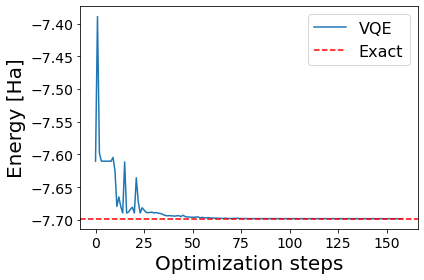

In [15]:
plt.plot(vqe_energies, label='VQE')
plt.axhline(exact_result.total_energies[0], color='red', linestyle='dashed', label='Exact')

plt.ylabel('Energy [Ha]', fontsize=20)
plt.xlabel('Optimization steps', fontsize=20)

plt.tick_params(which='both', labelsize=14)
plt.legend(fontsize=16)
plt.tight_layout()

### Additional material

* Qiskit tutorials related to the electronic Hamiltonian and solving for its ground state (and more) can be found [here](https://qiskit.org/ecosystem/nature/tutorials/index.html).
* Further readings: 
    * Peruzzo, A., et al. "A variational eigenvalue solver on a photonic quantum processor." [Nature communications 5.1 (2014): 4213](https://www.nature.com/articles/ncomms5213). 
    * Kandala, A., et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." [Nature 549.7671 (2017): 242-246](https://www.nature.com/articles/nature23879).

In [16]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright